Importing necessary modules

In [71]:
import pandas as pd
import numpy as np
import geopandas as gpd
import math
import matplotlib.pyplot as plt
import seaborn as sns

Importing the data and making new dataframe dat_num 

In [43]:
data = pd.read_csv("Ecommerce Customers.csv")
print(data.head())
data_num = data[["Avg. Session Length","Time on App","Time on Website","Length of Membership","Yearly Amount Spent"]]


                           Email  \
0      mstephenson@fernandez.com   
1              hduke@hotmail.com   
2               pallen@yahoo.com   
3        riverarebecca@gmail.com   
4  mstephens@davidson-herman.com   

                                             Address            Avatar  \
0       835 Frank Tunnel\nWrightmouth, MI 82180-9605            Violet   
1     4547 Archer Common\nDiazchester, CA 06566-8576         DarkGreen   
2  24645 Valerie Unions Suite 582\nCobbborough, D...            Bisque   
3   1414 David Throughway\nPort Jason, OH 22070-1220       SaddleBrown   
4  14023 Rodriguez Passage\nPort Jacobville, PR 3...  MediumAquaMarine   

   Avg. Session Length  Time on App  Time on Website  Length of Membership  \
0            34.497268    12.655651        39.577668              4.082621   
1            31.926272    11.109461        37.268959              2.664034   
2            33.000915    11.330278        37.110597              4.104543   
3            34.305557    

In [32]:
#data.describe()
#data.info()

In [33]:
#data.isnull().sum() #Überprüfung auf fehlende Werte je Spalte 

Adress analysis

In [83]:
list_shortcut_states = ["AK","AL","AR","AZ","CA","CO","CT","DE","FL","GA","HI","IA","ID","IL","IN","KS","KY","LA","MA","MD","ME","MI","MN","MO","MS","MT","NC","ND","NE","NH","NJ","NM","NV","NY","OH","OK","OR","PA","RI","SC","SD","TN","TX","UT","VA","VT","WA","WI","WV","WY"]
state_list = []

for i in data["Address"]:
    if "Box" in i:
        index_to_drop = data[data["Address"] == i].index.values 
        data.drop(index_to_drop, inplace = True)
    else:
        state = i.split(",")[-1].split()[0]

        if state in list_shortcut_states:
            state_list.append(state)
        else:
            index_to_drop = data[data["Address"] == i].index.values 
            data.drop(index_to_drop, inplace = True)


data.drop(["Email","Avatar","Address"], inplace = True, axis = 1)
data.insert(5, "State", state_list)

data_mixed = data
data_mixed.index = range(len(data_mixed.index))

#print(data_mixed.head(5))
#print(data_mixed.State.value_counts())



Distribution of customers among the states

  STATEFP   STATENS     AFFGEOID GEOID STUSPS        NAME LSAD          ALAND  \
0      02  01785533  0400000US02    02     AK      Alaska   00  1477946266785   
1      01  01779775  0400000US01    01     AL     Alabama   00   131173688951   
2      05  00068085  0400000US05    05     AR    Arkansas   00   134771517596   
3      04  01779777  0400000US04    04     AZ     Arizona   00   294198560125   
4      06  01779778  0400000US06    06     CA  California   00   403501101370   

         AWATER                                           geometry  Customers  
0  245390495931  MULTIPOLYGON (((-133.65582 55.62562, -133.6249...          7  
1    4593686489  MULTIPOLYGON (((-88.04374 30.51742, -88.03661 ...          9  
2    2960191698  POLYGON ((-94.61792 36.49941, -94.55929 36.499...          6  
3    1027346486  POLYGON ((-114.79968 32.59362, -114.80939 32.6...          9  
4   20466718403  MULTIPOLYGON (((-118.60337 33.47810, -118.5987...          6  


<AxesSubplot:>

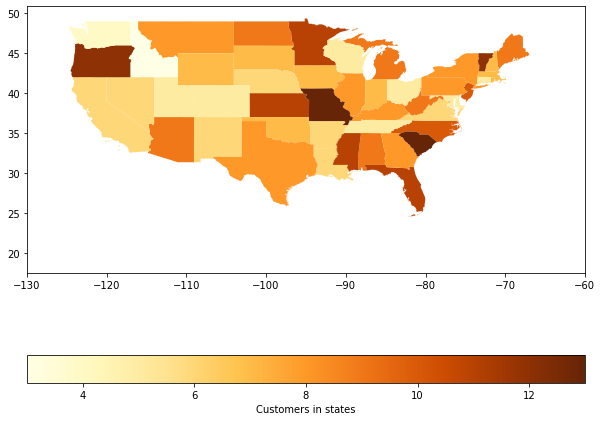

In [97]:
states_and_customers_list = data_mixed.State.value_counts()

states = gpd.read_file("cb_2016_us_state_5m\cb_2016_us_state_5m.shp")
#print(states.head(10))

geos_to_drop = [26,29,51,52,53,54]
states.drop(geos_to_drop, inplace=True)


states_50 = states
states_50.index = range(len(states_50.index))

states_50.sort_values('STUSPS', inplace= True)

states_50.loc[28,"STUSPS"] = "DE"
#print(states_50)

states_50 = states_50
states_50.index = range(len(states_50.index))


geo_list = []

for i in list_shortcut_states:
    #print(i," ",states_and_customers_list[i])
    geo_list.append(states_and_customers_list[i])
   
VALUES = gpd.GeoDataFrame(geo_list)

#print(states_50)


usa = pd.concat([states_50, VALUES], axis=1)
usa.columns = ["STATEFP","STATENS","AFFGEOID","GEOID","STUSPS","NAME","LSAD","ALAND","AWATER","geometry","Customers"]
print(usa.head())


indexes_to_drop = [0]
# Alaska got dropped for visualisation
usa.drop(indexes_to_drop, inplace=True)

fig = plt.figure(1, figsize=(10,10))
ax = fig.add_subplot()
plt.xlim(-130, -60)

usa.plot(column="Customers",ax=ax, legend= True, cmap="YlOrBr", legend_kwds = {"label": "Customers in states", "orientation":"horizontal"})

In [101]:
states_and_spent_list = []

for i in list_shortcut_states:
    state_rows = data_mixed.loc[data_mixed["State"] == i]

    state_spent = state_rows["Yearly Amount Spent"].sum()

    states_and_spent_list.append(state_spent)

#print(states_and_spent_list)
#print(usa.head())


states_and_spent_list = gpd.GeoDataFrame(states_and_spent_list)

print(states_and_spent_list.head())

usa_spent = pd.concat([usa, states_and_spent_list], axis=1)
usa.columns = ["STATEFP","STATENS","AFFGEOID","GEOID","STUSPS","NAME","LSAD","ALAND","AWATER","geometry","Customers","Avg. Amount Spent"]
print(usa_spent.head())

             0
0  3340.081851
1  4590.039942
2  3303.799262
3  4499.846756
4  2823.698434


ValueError: Length mismatch: Expected axis has 11 elements, new values have 12 elements

Creating new customer groups for clustering 

In [36]:
state_group_list = []

for i in data_mixed["State"]:
    # 12 - 10
    if i in (["MO","DE","SC","OR","VT","FL","MS","MN","KS","NJ","NC"]):
        state_group_list.append("HIGH")
    # 9 - 8
    if i in (["AZ","HI","AL","MI","WV","ME","ND","NY","IL","TX","PA","GA","KY","MT"]):
        state_group_list.append("MEDIUM")
    # 7 - 0
    if i in (["MA","OK","WY","IN","IA","SD","AK","NH","RI","CA","NV","NE","VA","LA","NM","AR","WI","OH","CT","MD","CO","TN","UT","WA","ID"]):
        state_group_list.append("LOW")

state_group_series_new = pd.Series(state_group_list)

data_mixed_new = pd.concat([data_mixed, state_group_series_new], axis=1)



data_mixed_new.columns = ["Avg. Session Length","Time on App","Time on Website","Length of Membership","Yearly Amount Spent","State","State group"]

print(data_mixed_new.head(5))

   Avg. Session Length  Time on App  Time on Website  Length of Membership  \
0            34.497268    12.655651        39.577668              4.082621   
1            31.926272    11.109461        37.268959              2.664034   
2            34.305557    13.717514        36.721283              3.120179   
3            33.871038    12.026925        34.476878              5.493507   
4            32.021596    11.366348        36.683776              4.685017   

   Yearly Amount Spent State State group  
0           587.951054    MI      MEDIUM  
1           392.204933    CA         LOW  
2           581.852344    OH         LOW  
3           637.102448    MN        HIGH  
4           521.572175    WV      MEDIUM  


One-hot encoding

In [47]:
hot_states = pd.get_dummies(data_mixed_new["State group"])
#print(hot_states.head(5))

data_hot_clustering = pd.concat([data_mixed_new,hot_states], axis=1)
print(data_hot_clustering.head(5))

   Avg. Session Length  Time on App  Time on Website  Length of Membership  \
0            34.497268    12.655651        39.577668              4.082621   
1            31.926272    11.109461        37.268959              2.664034   
2            34.305557    13.717514        36.721283              3.120179   
3            33.871038    12.026925        34.476878              5.493507   
4            32.021596    11.366348        36.683776              4.685017   

   Yearly Amount Spent State State group  HIGH  LOW  MEDIUM  
0           587.951054    MI      MEDIUM     0    0       1  
1           392.204933    CA         LOW     0    1       0  
2           581.852344    OH         LOW     0    1       0  
3           637.102448    MN        HIGH     1    0       0  
4           521.572175    WV      MEDIUM     0    0       1  


Email analysis

In [44]:
email_tail_list = []
email_series = data["Email"]

for i in email_series:
    head, sep, tail = i.partition("@")
    email_tail_list.append(tail)

email_tail_series = pd.Series(email_tail_list)

tail_cat_list = []

for i in email_tail_list:
    if i == "gmail.com":
        tail_cat_list.append(1)
    if i == "hotmail.com":
        tail_cat_list.append(2)
    if i == "yahoo.com":
        tail_cat_list.append(3)
    else:
        tail_cat_list.append(4)

email_new = pd.Series(tail_cat_list)

#print(email_new.head(15))
#print(email_new.value_counts())

Avatar analysis

In [68]:
#data["Avatar"].value_counts()

States and numerical variables

In [70]:
# states with high customer numbers and yearly amount spent
high = data_hot_clustering.loc[data_hot_clustering["HIGH"] == 1]
#print(high.describe())

# states with medium customer numbers and yearly amount spent
medium = data_hot_clustering.loc[data_hot_clustering["MEDIUM"] == 1]
#print(medium.describe())

# states with low customer numbers and yearly amount spent
low = data_hot_clustering.loc[data_hot_clustering["LOW"] == 1]
#print(low.describe())

       Avg. Session Length  Time on App  Time on Website  \
count           147.000000   147.000000       147.000000   
mean             33.018810    12.098547        36.907439   
std               1.072204     1.056683         0.966370   
min              30.393185     8.508152        34.845612   
25%              32.245061    11.401917        36.164845   
50%              33.066441    11.947175        36.881192   
75%              33.751230    12.742539        37.564858   
max              36.139662    15.126994        39.252931   

       Length of Membership  Yearly Amount Spent   HIGH    LOW  MEDIUM  
count            147.000000           147.000000  147.0  147.0   147.0  
mean               3.535615           500.631768    0.0    1.0     0.0  
std                1.028044            83.048603    0.0    0.0     0.0  
min                0.801516           282.471246    0.0    1.0     0.0  
25%                2.982701           444.415729    0.0    1.0     0.0  
50%                3.

Correlations

pearson == 1 (perfect positive linear)

In [64]:
print(data_hot_clustering["Avg. Session Length"].corr(data_hot_clustering["Yearly Amount Spent"], method="pearson"))

print(data_hot_clustering["Time on App"].corr(data_hot_clustering["Yearly Amount Spent"], method="pearson"))

print(data_hot_clustering["Length of Membership"].corr(data_hot_clustering["Yearly Amount Spent"], method="pearson"))

0.35630437759327227
0.5118006833003252
0.8004927610508866
